<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-&amp;-Data" data-toc-modified-id="Import-Packages-&amp;-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages &amp; Data</a></span></li><li><span><a href="#EDA-&amp;-Cleaning" data-toc-modified-id="EDA-&amp;-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA &amp; Cleaning</a></span></li></ul></div>

# Import Packages & Data

In [1]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import data

data = pd.read_csv('Data/CLEAN_REFIT_081116/CLEAN_House3.csv')
df = pd.DataFrame(data)

# EDA & Cleaning

Preview data

In [3]:
# Preview data

df.head()

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,2013-09-25 19:21:09,1380136869,387,0,0,86,0,0,0,145,0,0,0
1,2013-09-25 19:21:16,1380136876,386,0,0,86,0,0,0,144,0,0,0
2,2013-09-25 19:21:23,1380136883,383,0,0,86,0,0,0,144,0,0,0
3,2013-09-25 19:21:30,1380136890,388,0,0,87,0,0,0,145,0,0,0
4,2013-09-25 19:21:37,1380136897,388,0,0,86,0,0,0,145,0,0,0


We're going to use datetime index rather than unix. Could use unix, however since that's universal time, having local daily hours will be more relevant to energy usage. So we will use local time instead. 

Converting index to datetime will make it easy to plot energy usage. 

In [4]:
# Convert index to datetime

df.index = pd.to_datetime(df.Time)

Now that we have datetime as index we can drop the Time column. I'll drop Unix as well, and we can always come back and add it if we decide we need/want to use it. I'm going to check for issues too and if no issues, will come back and drop that column as well. 

In [5]:
df = df.drop(['Time','Unix'], axis=1)
df.head()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
Time,,,,,,,,,,,
2013-09-25 19:21:09,387,0,0,86,0,0,0,145,0,0,0
2013-09-25 19:21:16,386,0,0,86,0,0,0,144,0,0,0
2013-09-25 19:21:23,383,0,0,86,0,0,0,144,0,0,0
2013-09-25 19:21:30,388,0,0,87,0,0,0,145,0,0,0
2013-09-25 19:21:37,388,0,0,86,0,0,0,145,0,0,0


From the 'CLEAN_READ_ME_081116.txt' file with the dataset we used, it says that the Issues column "is set to 1 if the sum of the sub-metering (IAMs) is greater than that of the household aggregate. In these cases the data should be discarded or noted that there is a discrepancy." So we will remove data that satisfy these criteria. 

Let's calculate and see how much of our data this represents.

In [18]:
# Percentage of data with discrepancy

print(f'Percentage of data w/discrepancy: \n{round(len(df[df.Issues == 1])/len(df)*100,2)} %')

Percentage of data w/discrepancy: 
5.84 %


Cool. That's not too much at all. We'll go ahead and remove that data now and then drop the issues column. 

In [20]:
# Drop data w/discrepancy
df = df[df.Issues == 0]

# Drop Issues column
df = df.drop('Issues', axis=1)

# Preview
df.head()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
Time,,,,,,,,,,
2013-09-25 19:21:09,387,0,0,86,0,0,0,145,0,0
2013-09-25 19:21:16,386,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:23,383,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:30,388,0,0,87,0,0,0,145,0,0
2013-09-25 19:21:37,388,0,0,86,0,0,0,145,0,0


Let's preview our Aggregate column, which represents all appliances. 

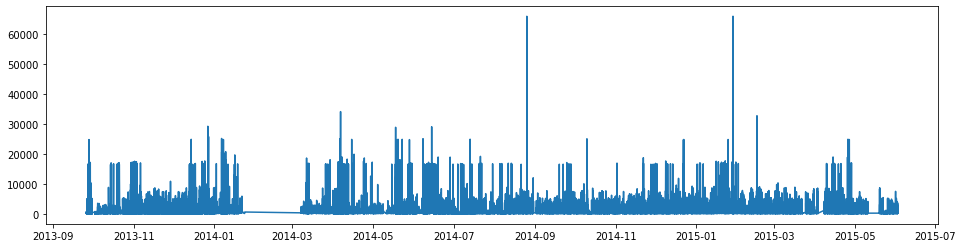

In [26]:
plt.figure(figsize=(16,4))
plt.plot(df.Aggregate)
plt.show()